In [2]:
# import and set options
import warnings
warnings.filterwarnings("ignore")
import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')
import rpy2
%load_ext rpy2.ipython
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import os
import scipy.stats as stats
import matplotlib as mpl
import utils
mpl.rcParams['pdf.fonttype'] = 42

## Summary of CHASM2 discovery analysis

We trained CHASM2 using a unified set of somatic mutation calls from The Cancer Genome Atlas (TCGA) covering 8,657 samples over 32 cancer types (Figure 1b, Table S1, online methods). All predictions were performed using gene hold-out cross-validation, thus avoiding over fitting by ensuring all mutations within a gene are within the same fold. Using CHASM2, we identified 3,527 unique SMMs as statistically significant drivers by the pan-cancer analysis at an estimated false discovery rate of 1% (Supplementary Table 4). When applied to each cancer type individually, the number found significant varied substantially from 8 in THYM to 572 in BLCA with a median of 78 (Figure 3a, Supplementary Table 5). 

### Read mutations

In [29]:
# read in significant mutations
df = utils.read_all_results()

### OncoKB Analysis

We used OncoKB -- a literature curated database -- to estimate how many mutations have prior evidence from the literature.

In [30]:
#read oncokb
oncokb = pd.read_table('CHASM2/data/oncokb_4_3_2017_v2.txt')
oncokb['HGVSp_Short'] = 'p.' + oncokb['Alteration']
oncokb = oncokb.rename(columns={'Gene': 'Hugo_Symbol'})
oncokb['OncoKB'] = oncokb['Oncogenicity'].isin(['Oncogenic', 'Likely Oncogenic']).astype(int)

# merge in oncokb annotations
merge_cols = ['Hugo_Symbol', 'HGVSp_Short']
merged_df = pd.merge(df, oncokb[merge_cols+['OncoKB']], on=merge_cols, how='left')
merged_df['OncoKB'] = merged_df['OncoKB'].fillna(0)
is_tp53 = merged_df['Hugo_Symbol']=='TP53'
is_dna_bind_domain = (merged_df['Protein_position'].astype(int)>=102) & (merged_df['Protein_position'].astype(int)<=292)
merged_df.loc[is_tp53 & is_dna_bind_domain, 'OncoKB'] = 1

# make a flag column for oncokb
merged_df['OncoKB_flag'] = 'No'
merged_df.loc[(merged_df['OncoKB']==1), 'OncoKB_flag'] = 'Yes'
merged_df.loc[(merged_df['Hugo_Symbol']=='TP53') & (merged_df['OncoKB']==1), 'OncoKB_flag'] = 'Yes (TP53)'

In [31]:
# simply count the significant
mycols = ['ACC_flag', u'BLCA_flag', u'BRCA_flag',
          'CESC_flag', u'CHOL_flag', u'COAD_flag', 
          'DLBC_flag', u'ESCA_flag', u'GBM_flag', 
          'HNSC_flag', u'KICH_flag', u'KIRC_flag',
          'KIRP_flag', u'LAML_flag', u'LGG_flag', 
          'LIHC_flag', u'LUAD_flag', u'LUSC_flag', 
          'MESO_flag', u'OV_flag', u'PAAD_flag', 
          'PCPG_flag', u'PRAD_flag', u'READ_flag',
          'SARC_flag', u'STAD_flag', u'TGCT_flag',
          'THCA_flag', u'THYM_flag',  u'UCEC_flag',
          'UCS_flag', u'UVM_flag',]
tmp_df = pd.melt(merged_df, value_vars=mycols, id_vars='OncoKB_flag', value_name='significant', var_name='cancer type').dropna()
tmp_df = tmp_df[tmp_df['significant']==1]
tmp2_df = tmp_df.groupby('cancer type')['OncoKB_flag'].value_counts().reset_index(name='number of mutations')
plot_df = tmp2_df.pivot_table('number of mutations',  'OncoKB_flag', 'cancer type').fillna(0)
rename_dict = {c: c.split('_')[0] for c in plot_df.columns}
plot_df = plot_df.rename(columns=rename_dict)

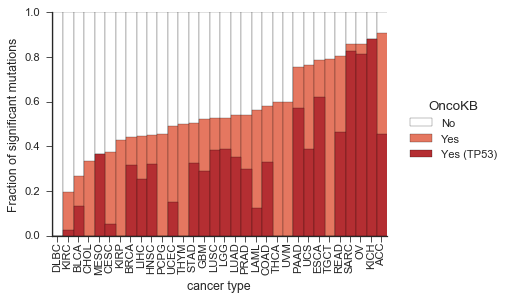

In [32]:
num_oncokb = plot_df.loc[['Yes', 'Yes (TP53)'],:].sum()
num_oncokb_tp53 = plot_df.loc['Yes (TP53)',:]
total = plot_df.sum()
frac_oncokb = num_oncokb / total
frac_oncokb = frac_oncokb.sort_values()
frac_oncokb_tp53 = num_oncokb_tp53 / total
with sns.axes_style('ticks'), sns.plotting_context('paper', font_scale=1.4):
    # plot the barplot
    one_list = [1 for i in range(len(total))]
    sns.barplot(frac_oncokb.index, one_list, 
                color='white', label='No')
    sns.barplot(frac_oncokb.index, frac_oncokb, 
                color=sns.color_palette("Reds", 3)[1], label='Yes')
    sns.barplot(frac_oncokb.index, frac_oncokb_tp53[frac_oncokb.index], 
                color=sns.color_palette("Reds", 3)[2], label='Yes (TP53)')
    
    # tweak axis
    sns.despine()
    myleg = plt.legend(loc='upper center', title='OncoKB', bbox_to_anchor=(1.2, .65), ncol=1)
    plt.ylabel('Fraction of significant mutations')
    plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=90, ha='center')
    plt.gca().tick_params(axis='x', which='major', pad=0)
    
    # max bars full width
    myax = plt.gca()
    for bar in myax.patches:
        bar.set_width(1)
        
    # save figure
    plt.gcf().set_size_inches(6,4)
    #plt.savefig('CHASM2/figures/fraction_onckb.pdf', bbox_inches='tight', bbox_extra_artists=[myleg])

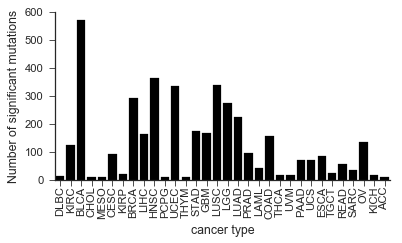

In [11]:
with sns.axes_style('ticks'), sns.plotting_context('paper', font_scale=1.4):
    sns.barplot(frac_oncokb.index, total[frac_oncokb.index], color='black')
    
    # tweak formatting
    plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=90, ha='center')
    plt.gca().tick_params(axis='x', which='major', pad=0)
    sns.despine()
    plt.ylabel('Number of significant mutations')
    
    # save figure
    plt.gcf().set_size_inches(6, 3)
    #plt.savefig('CHASM2/figures/number_signif.pdf')

### Analyze mutation rarity

Analyze the rarity of significant mutations.

#### CHASM2

Analyze the rarity of mutations found significant by CHASM2.

In [26]:
# read in information about the rarity of drivers
rare_df = utils.read_all_rarity_results(base_dir='CHASM2/data/rarity_analysis_v2/')

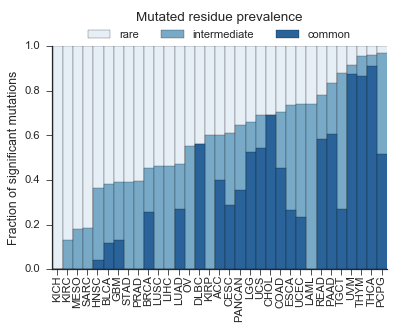

In [27]:
intermediate = rare_df.loc[['common', 'intermediate'],:].sum().sort_values()
common = rare_df.loc['common',:]
with sns.axes_style('ticks'), sns.plotting_context('paper', font_scale=1.4):
    sns.barplot(intermediate.index, [1]*len(common), color=sns.color_palette("Blues", 9)[0], label='rare')
    sns.barplot(intermediate.index, intermediate[intermediate.index], color=sns.color_palette("Blues", 9)[4], label='intermediate')
    sns.barplot(intermediate.index, common[intermediate.index], color=sns.color_palette("Blues", 9)[7], label='common')
    sns.despine()
    myleg = plt.legend(loc='upper center', title='Mutated residue prevalence', bbox_to_anchor=(.5, 1.2), ncol=3)
    plt.ylabel('Fraction of significant mutations')
    plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=90, ha='center')
    plt.gca().tick_params(axis='x', which='major', pad=0)
    #plt.gca().set_ylim((0, 90))
    
    # max barwidths fill the complete width
    myax = plt.gca()
    for bar in myax.patches:
        bar.set_width(1)
    
    # save figure
    plt.gcf().set_size_inches(6, 4)
    #plt.savefig('CHASM2/figures/mutation_rarity.pdf', bbox_inches='tight', bbox_extra_artists=[myleg])

#### Hotspots (Chang et al.)

Analyze rarity from the hotspots method by Chang et al.

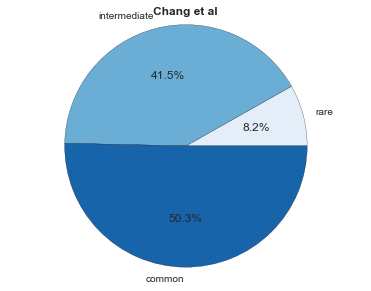

In [25]:
rare_chang_df = pd.read_table('CHASM2/data/rarity_chang_et_al_pancan.txt')
chang_counts = rare_chang_df.groupby('category')['number of mutations'].sum()
with sns.plotting_context('paper', font_scale=1.25):
    blues = sns.color_palette("Blues", 9)
    pie_colors = [blues[0], blues[4], blues[7]]
    labels = ['rare', 'intermediate', 'common']
    plt.pie(chang_counts[labels], colors=pie_colors, labels=labels, autopct='%.1f%%')
    plt.title('Chang et al', fontdict={'verticalalignment': 'bottom', 'fontweight': 'bold'})
    _ = plt.axis('equal')

#### Comparison between CHASM2 and Hotspots

In [71]:
rare_chasm2_df = pd.read_table('CHASM2/data/rarity_analysis_v2/PANCAN.txt')
chasm2_counts = rare_chasm2_df.groupby('category')['number of mutations'].sum()

# compare using a fisher exact test
chasm2_nonrare = chasm2_counts.loc[['common', 'intermediate']].sum()
chasm2_rare = chasm2_counts.loc['rare']
chang_nonrare = chang_counts.loc[['common', 'intermediate']].sum()
chang_rare = chang_counts.loc['rare']
contigency_table = np.array([[chasm2_rare, chang_rare], [chasm2_nonrare, chang_nonrare]])

In [72]:
%%R -i contigency_table
fisher.test(contigency_table)


	Fisher's Exact Test for Count Data

data:  contigency_table
p-value < 2.2e-16
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 5.618475 6.794491
sample estimates:
odds ratio 
  6.174854 



We next create a venn diagram examining the overlap between the residues identified as significant by each method.

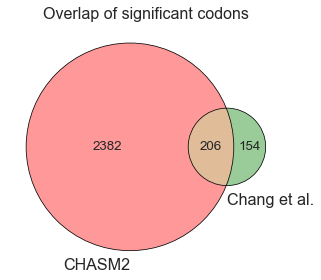

In [73]:
from matplotlib_venn import venn2, venn2_circles

# overlap the two
chasm2_pos = list((pancan_df['Hugo_Symbol'] + '_' + pancan_df['Protein_position_x'].astype(str)).unique())
chang_pos = list(rare_chang_df.mutation.unique())
len_intersect = len(set(chasm2_pos) & set(chang_pos))
len_chasm2 = len(chasm2_pos)
len_chang = len(chang_pos)
overlap = (len_chasm2 - len_intersect, len_chang - len_intersect, len_intersect)

# plot venn diagram
with sns.plotting_context('paper', font_scale=1.4):
    venn2(subsets=overlap, set_labels=('CHASM2', 'Chang et al.'))
    venn2_circles(subsets=overlap, linestyle='solid', linewidth=.75)
    plt.title('Overlap of significant codons', size=16)

#### Prepare chimera

In [76]:
tmp = rare_chasm2_df.mutation.str.split('_', expand=True)
rare_chasm2_df['gene'] = tmp[0]

In [111]:
is_gene = rare_chasm2_df['gene']=='ERBB2'
format_func = lambda x: ','.join([str(t.split('_')[-1])+'.A' for t in x.mutation])
rare_chasm2_df[is_gene].groupby('category').apply(format_func)

category
common                                                    310.A
intermediate                                  755.A,776.A,842.A
rare            313.A,662.A,678.A,733.A,756.A,767.A,769.A,777.A
dtype: object

In [109]:
df[(df['PANCAN']<=0.01) & (df['Hugo_Symbol']=='ERBB2')]['HGVSp_Short']

41037     p.S310A
48296     p.R678Q
50191     p.V777L
64916     p.S310F
94410     p.L755S
201519    p.L755M
201520    p.L755W
221617    p.G776V
222115    p.T733I
237828    p.V842I
274007    p.D769Y
306519    p.D769H
307919    p.I767M
402214    p.L313V
402428    p.D769N
489072    p.S310Y
514088    p.G776S
522923    p.L662Q
596938    p.R756K
596939    p.I767F
Name: HGVSp_Short, dtype: object

### Gene heatmap

Examine the most frequent cancer type specific predictions by CHASM2. First, we process the data.

In [33]:
# melt the data frame
cancer_types = [os.path.basename(f)[:-4] for f in glob.glob('{0}/*.txt'.format('CHASM2/data/aggregated_results/')) if 'PANCAN' not in f]
merged2_df = pd.melt(merged_df, 
                     id_vars=['Hugo_Symbol', 'Transcript_ID', 'HGVSp_Short'], value_vars=cancer_types+['PANCAN'],
                     var_name='CODE', value_name='qvalue')
merged2_df = merged2_df.dropna()
merged2_df['Protein_position'] = merged_df['HGVSp_Short'].str[3:-1]

# merge with 
mut_df = pd.read_table('CHASM2/data/aggregated_results/PANCAN.maf')
mut_df = pd.merge(mut_df, merged2_df, 
                  on=['Hugo_Symbol', 'Transcript_ID', 'HGVSp_Short', 'CODE'],
                  how='left')

We then create a heatmap of the top 25 genes based on driver frequency.

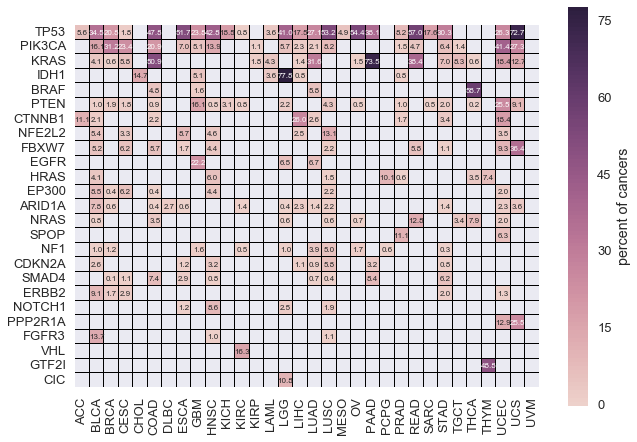

In [72]:
from matplotlib.colors import ListedColormap

# calc mutation frequency
mutated_samps = mut_df[mut_df['qvalue']<=.01].groupby(['CODE', 'Hugo_Symbol'])['Tumor_Sample_Barcode'].nunique()
order = mutated_samps.reset_index(name='number of mutations').groupby('Hugo_Symbol')['number of mutations'].sum().sort_values(ascending=False).index.tolist()[:25]
total_samps = mut_df.groupby('CODE')['Tumor_Sample_Barcode'].nunique()
frac_mutated_samps = (mutated_samps / total_samps).reset_index(name='fraction of samples')

# create heatmap
plot_df_orig = frac_mutated_samps.pivot('CODE', 'Hugo_Symbol', 'fraction of samples')
plot_df = plot_df_orig.fillna(0)
with sns.plotting_context('talk', font_scale=1.):
    cm = sns.heatmap(100*plot_df.loc[:, order].T, 
                     square=True, 
                     linewidth=.01, linecolor='black', fmt='.1f',
                     annot=100*plot_df_orig.loc[:, order].T,
                     annot_kws={'fontsize': 8},
                     mask=plot_df_orig.loc[:, order].T.isnull(),
                     cbar=True,
                     cbar_kws={'label': 'percent of cancers'},
                     cmap = ListedColormap(sns.color_palette(sns.cubehelix_palette(100).as_hex())))

# modify display of plot
plt.ylabel('')
plt.xlabel('')
_ = plt.setp(cm.yaxis.get_majorticklabels(), rotation=0)
_ = plt.setp(cm.xaxis.get_majorticklabels(), rotation=90, ha='center', va='top')

# save figure
#plt.gcf().set_size_inches(16, 5)
#plt.savefig('CHASM2/figures/gene_heatmap.pdf')

### Prepare supplementary tables

Prepare supplementary table 4 showing the significant missense mutations for the pancancer analysis.

In [11]:
pancan_df = utils.read_result('PANCAN', only_significant=True)
dup_cols = ['Hugo_Symbol', 'Transcript_ID', 'HGVSp_Short']
supp_table4 = pancan_df.drop_duplicates(dup_cols).sort_values(['CHASM2_genome'], ascending=False)
result_cols = ['CODE', 'Hugo_Symbol', 'Transcript_ID', 'HGVSp_Short', 'CHASM2_genome', 'CHASM2_genome_pval', 'PANCAN']
#supp_table4[result_cols].to_csv('CHASM2/results/supplementary_table_4_pancan_drivers.txt', sep='\t', index=False)

Prepare supplementary table 5 showing the cancer type specific drivers

In [35]:
is_signif = mut_df['qvalue']<=0.01
dup_cols = ['Hugo_Symbol', 'Transcript_ID', 'HGVSp_Short', 'CODE']
supp_table5 = mut_df[is_signif].drop_duplicates(dup_cols)
supp_table5 = supp_table5.sort_values(['CODE', 'Hugo_Symbol', 'qvalue'])
result_cols = ['CODE', 'Hugo_Symbol', 'Transcript_ID', 'HGVSp_Short', 'qvalue']
supp_table5[result_cols].to_csv('CHASM2/results/supplementary_table_5_cancer_specific_drivers.txt', sep='\t', index=False)